<center>
    <h1>Room Occupancy Estimation - DM, TM and BDA</h1>
    <h2>Multi Layer Perceptron</h2>
    <h3>Riccardo Spolaor</h3>
    <h4>riccardo.spolaor@studio.unibo.it</h4>
</center>

---
In this notebook the prediction task on the ***Room Occupancy Estimation*** dataset is carried out by means of a Multi Layer Perceptron.

## Settings

In [1]:
import sys

IS_COLAB = 'google.colab' in sys.modules

In [2]:
SEED=42

In [3]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [4]:
# Matplotlib settings

%matplotlib inline

In [5]:
NUM_FOLDS = 10
APPLY_THRESHOLD_SELECTION = True

## Libraries

In [6]:
if IS_COLAB:
    !pip install pyspark
    !pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=676280e877d2c1bd5b4a6c83a61dd30f937fe8c81429736ab58a97d825e28b94
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [7]:
import findspark

findspark.init()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import pyspark.sql.functions as F

## Setting Spark Session

In [10]:
from pyspark.sql import SparkSession


# Create a spark session
spark = SparkSession.builder.master('local[*]').appName('OccupancyEstimation').getOrCreate()

In [11]:
if not IS_COLAB:
    # Put the local file in the nodes.
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -mkdir /input
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -mkdir /input/processed
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -put input/processed/train.csv /input/processed/train.csv
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -put input/processed/test.csv /input/processed/test.csv

## Get the train and test data

In [12]:
import os


if IS_COLAB:
    train_path = os.path.join('.', 'input', 'processed', 'train.csv')
    test_path = os.path.join('.', 'input', 'processed', 'test.csv')
else:
    train_path = os.path.join('/', 'input', 'processed', 'train.csv')
    test_path = os.path.join('/', 'input', 'processed', 'test.csv')

In [13]:
train = spark.read.csv(
    train_path,
    header=True,
    inferSchema=True)

test = spark.read.csv(
    test_path,
    header=True,
    inferSchema=True)

In [14]:
train.printSchema()
test.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- S1_Temp: double (nullable = true)
 |-- S2_Temp: double (nullable = true)
 |-- S3_Temp: double (nullable = true)
 |-- S4_Temp: double (nullable = true)
 |-- S1_Light: integer (nullable = true)
 |-- S2_Light: integer (nullable = true)
 |-- S3_Light: integer (nullable = true)
 |-- S4_Light: integer (nullable = true)
 |-- S1_Sound: double (nullable = true)
 |-- S2_Sound: double (nullable = true)
 |-- S3_Sound: double (nullable = true)
 |-- S4_Sound: double (nullable = true)
 |-- S5_CO2: integer (nullable = true)
 |-- S5_CO2_Slope: double (nullable = true)
 |-- S6_PIR: integer (nullable = true)
 |-- S7_PIR: integer (nullable = true)
 |-- Room_Occupancy_Count: integer (nullable = true)

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- S1_Temp: double (nullable = true)
 |-- S2_Temp: double (nullable = true)
 |-- S3_Temp: double (nullable = true)
 |-- S4_Temp: double (nullable =

In [15]:
print('Number of train instances:', train.count())
print('Number of test instances:', test.count())

Number of train instances: 8036
Number of test instances: 2093


## Dataset Processing
In this section the dataset is processed, by adding a weight column to each instance inversely proportional to the frequency of their label, in order to address the issue of class imbalance.

The applied weight $w$, to an instance $x$ of the train dataset $\mathcal{D}$ with label $c$, is assigned by this formula:
$$w(x) = \frac{\text{lenght}(\mathcal{D})}{\text{lenght}(\mathcal{C}) \cdot \text{lenght}(\mathcal{D}_{c})}$$
where $\mathcal{D}_{c}$ is the fraction of the train dataset containing label $c$ and $\mathcal{C}$ is the set of possible labels.

Furthermore a fold column is added, to identify for each instance in which fold of the *K-fold Cross Validation* it is part of.
The folds are computed by dividing each day in $10$ different parts while guaranteeing that each fold contains a number of instances of each label that represents the distribution of the training set. Subsequent instances for each label are assigned to the same fold.

In [16]:
from pyspark.ml.feature import StandardScaler, RFormula


rf = RFormula(formula='Room_Occupancy_Count ~ . - Date - Time')
rf_fit = rf.fit(train)
train = rf_fit.transform(train).select('features', 'label', 'Date', 'Time')
test = rf_fit.transform(test).select('features', 'label', 'Date', 'Time')

In [17]:
train.show(n=5)
test.show(n=5)

+--------------------+-----+----------+-------------------+
|            features|label|      Date|               Time|
+--------------------+-----+----------+-------------------+
|[24.94,24.75,24.5...|  1.0|2017-12-22|2023-11-22 10:49:41|
|[24.94,24.75,24.5...|  1.0|2017-12-22|2023-11-22 10:50:12|
|[25.0,24.75,24.5,...|  1.0|2017-12-22|2023-11-22 10:50:42|
|[25.0,24.75,24.56...|  1.0|2017-12-22|2023-11-22 10:51:13|
|[25.0,24.75,24.56...|  1.0|2017-12-22|2023-11-22 10:51:44|
+--------------------+-----+----------+-------------------+
only showing top 5 rows

+--------------------+-----+----------+-------------------+
|            features|label|      Date|               Time|
+--------------------+-----+----------+-------------------+
|[25.94,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:00:23|
|[25.94,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:00:53|
|[25.94,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:01:24|
|[25.88,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:01:55|
|[25.88,26.0,25

In [18]:
from utils import get_df_with_weight_column


# Add weight column inversely proportional to train frequency of the label.
train = get_df_with_weight_column(train)

In [19]:
train.select('label', 'weightCol').distinct().orderBy('label').show()

+-----+-------------------+
|label|          weightCol|
+-----+-------------------+
|  0.0|0.30374962201390987|
|  1.0|  6.069486404833837|
|  2.0|   3.20414673046252|
|  3.0|  4.329741379310345|
+-----+-------------------+



In [20]:
from utils import get_df_with_fold_column


# Add the column for stratified k-fold.
train = get_df_with_fold_column(train, NUM_FOLDS)

In [21]:
# Drop the Date and Time features.
train = train.drop('Date', 'Time')
test = test.drop('Date', 'Time')

In [22]:
train.groupBy('foldCol', 'label').count().orderBy('foldCol', 'label').show()

+-------+-----+-----+
|foldCol|label|count|
+-------+-----+-----+
|      0|  0.0|  664|
|      0|  1.0|   34|
|      0|  2.0|   64|
|      0|  3.0|   48|
|      1|  0.0|  662|
|      1|  1.0|   33|
|      1|  2.0|   63|
|      1|  3.0|   46|
|      2|  0.0|  661|
|      2|  1.0|   34|
|      2|  2.0|   62|
|      2|  3.0|   46|
|      3|  0.0|  662|
|      3|  1.0|   32|
|      3|  2.0|   64|
|      3|  3.0|   47|
|      4|  0.0|  660|
|      4|  1.0|   33|
|      4|  2.0|   61|
|      4|  3.0|   46|
+-------+-----+-----+
only showing top 20 rows



In [23]:
train.show(n=5)

+-----+--------------------+-----------------+-------+
|label|            features|        weightCol|foldCol|
+-----+--------------------+-----------------+-------+
|  1.0|[24.94,24.75,24.5...|6.069486404833837|      0|
|  1.0|[24.94,24.75,24.5...|6.069486404833837|      0|
|  1.0|[25.0,24.75,24.5,...|6.069486404833837|      0|
|  1.0|[25.0,24.75,24.56...|6.069486404833837|      0|
|  1.0|[25.0,24.75,24.56...|6.069486404833837|      0|
+-----+--------------------+-----------------+-------+
only showing top 5 rows



## K-Fold Cross Validation Training
In this section a pipeline is built for the Multi Layer Perceptron Classifier model. The seed is set as $42$. Furthermore, the features are standardized through *Standard Scaling*, as normalized features should bring to better results for the given model. The model is not built to take care of the weights of the classes.

*10-Fold Cross Validation* is then applied for different parameters, namely:
* `solver`
* `maxIter`
* `stepSize`:
* `layers`
    * (input_size, (input_size + num_classes) / $2$, num_classes)
    * (input_size, (input_size + num_classes) / $2$, (input_size + num_classes) / $2$, num_classes)

In [24]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline, PipelineModel

def get_pipeline() -> PipelineModel:
    ss = StandardScaler(inputCol='features', outputCol='scaledFeatures', withMean=True, withStd=True)

    # Create Perceptron Classifier.
    mlp = MultilayerPerceptronClassifier(
        seed=SEED,
        featuresCol='scaledFeatures')

    return Pipeline(stages=[ss, mlp])

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Cache the df.
cached = train.cache()

pipeline = get_pipeline()
mlp = pipeline.getStages()[-1]


in_size = len(train.select('features').head(1)[0].features)
out_size = len(train.select('label').distinct().collect())
hid_size = (in_size + out_size) // 2

# Build the Parameter Grid.
mlp_param_grid = ParamGridBuilder()\
    .addGrid(mlp.solver, ['l-bfgs', 'gd'])\
    .addGrid(mlp.maxIter, [20, 50, 100])\
    .addGrid(mlp.stepSize, [3e-1, 3e-2, 3e-3])\
    .addGrid(mlp.layers, [
        [in_size, hid_size, out_size],
        [in_size, hid_size, hid_size, out_size]])\
    .build()

# Set the Cross Validator.
mlp_cross_val = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=mlp_param_grid,
    evaluator=MulticlassClassificationEvaluator(
        metricName='f1', weightCol='weightCol'),
    numFolds=NUM_FOLDS,
    parallelism=NUM_FOLDS,
    collectSubModels=True,
    seed=SEED,
    foldCol='foldCol')

In [26]:
fit = mlp_cross_val.fit(cached)

In [27]:
print('Best parameters:')
for k, v in fit.getEstimatorParamMaps()[np.argmax(fit.avgMetrics)].items():
    print(f'- {k.name}: {v}')

Best parameters:
- solver: l-bfgs
- maxIter: 100
- stepSize: 0.3
- layers: [16, 10, 4]


## Average Results on the Validation Folds
In this section, the average results of *Cross Validation* of the model with the best found hyperparameters are computed and shown.

Furthermore, threshold selection is applied, by chosing for each label the the threshold that improves its average *F1* validation score across the folds.

The threshold $t$ changes the forecasted probability $p_c$ of an instance $x$ being part of label $c$, by computing a new probability $p_c'$, such that:
$$p_c'(x) = \frac{p_c(x)}{t}$$

Threshold selection is applied in a *OneVsRest* approximation. In other words, given a class $c$ and a threshold $t$ to test, all the other classes are combined in a class $\overline{c}$ and their probabilities are summed. The threshold for $\overline{c}$ is set at $0.5$ and the predicted label of each instance $x$ is computed as follows:

$$\text{class of} \ x =
\begin{cases}
    c, & \text{if} \ p_c(x) / t \geq p_{\overline{c}}(x) / 0.5 \\
    \overline{c}, & \text{otherwise}
\end{cases}$$

In [28]:
from utils import get_average_validation_results


avg_validation_results = get_average_validation_results(
    fit,
    train,
    apply_threshold_selection=APPLY_THRESHOLD_SELECTION)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Average Cross Validation Metrics:
Accuracy: 0.988
F1 Macro: 0.960
F1 scores:
	Label 0: 0.998
	Label 1: 0.992
	Label 3: 0.904
	Label 2: 0.945


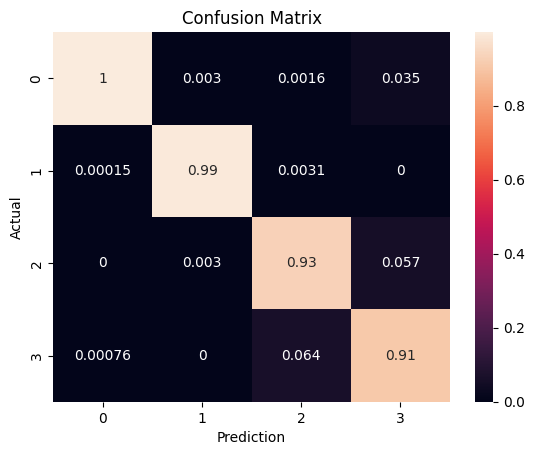

In [29]:
from utils import print_results


print('Average Cross Validation Metrics:')
print_results(
    avg_validation_results['average accuracy'],
    avg_validation_results['average F1 macro'],
    avg_validation_results['average F1 scores'],
    avg_validation_results['average confusion matrix'])

The model seems to predict very good average results for each class in the k-folded validation set. Label $3$ seems to be the hardest to predict, but the metric results are not that much lower.

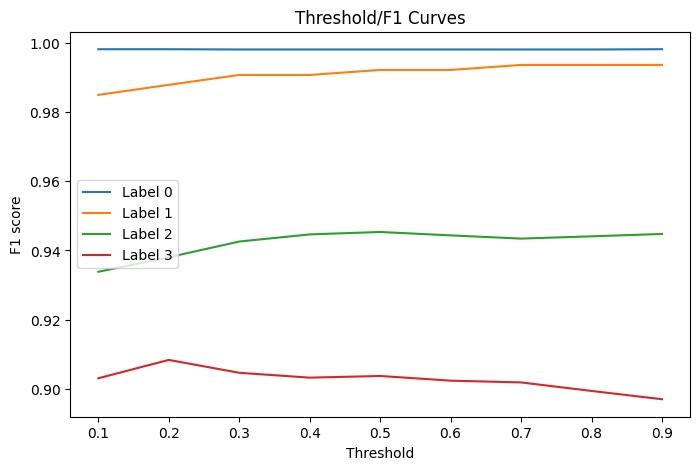

In [30]:
if APPLY_THRESHOLD_SELECTION:
    plt.figure(figsize=(8, 5))
    plt.title(f'Threshold/F1 Curves')
    for k, v in avg_validation_results['average F1 scores by threshold'].items():
        x_val = list(v.keys())
        y_val = [v1 for v1 in v.values()]
        plt.plot(x_val, y_val, label=f'Label {int(k)}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 score')
    plt.legend()
    plt.show()

## Test Results
In this section the results are plotted for the test set, with the model containing the best found hyperparameters with and without threshold selection.

In [31]:
fit_final = fit.bestModel

In [32]:
preds = fit_final.transform(test)

In [33]:
from utils import get_metrics


fit_final_metrics = get_metrics(
    preds,
    normalize_confusion_matrix=True)

Test results:
Accuracy: 0.980
F1 Macro: 0.938
F1 scores:
	Label 0: 0.998
	Label 1: 0.942
	Label 2: 0.877
	Label 3: 0.935


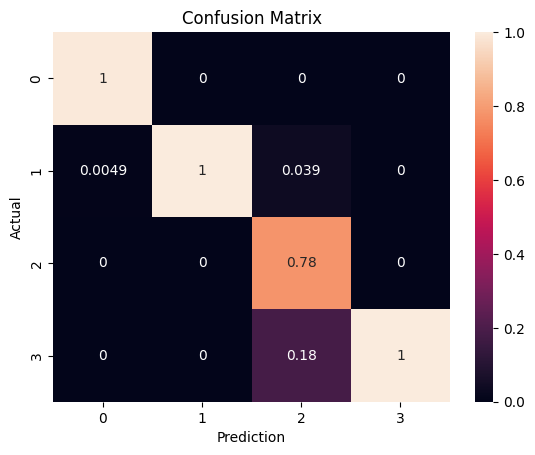

In [34]:
from utils import print_results


print('Test results:')
print_results(
    fit_final_metrics['accuracy'],
    fit_final_metrics['F1 macro'],
    fit_final_metrics['F1 scores'],
    fit_final_metrics['confusion matrix'])

The results are pretty good in the test set as well. Slightly average *F1* results are obtained for label $2$.

In [35]:
if APPLY_THRESHOLD_SELECTION:
    best_thresholds = {
        k: max(v, key=v.get)
        for k, v in avg_validation_results['average F1 scores by threshold'].items()}
else:
    best_thresholds = { 0.: .5, 1.: .5, 2.:.5, 3: .5 }

In [36]:
fit_final_thresholds = fit_final.copy()
fit_final_thresholds.stages[-1].setThresholds(
    list(dict(sorted(best_thresholds.items())).values()))

MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_f2206f80ef0c, numLayers=3, numClasses=4, numFeatures=16

In [37]:
fit_final_thresholds.stages[-1].getThresholds()

[0.1, 0.7000000000000001, 0.5, 0.2]

In [38]:
preds = fit_final_thresholds.transform(test)

In [39]:
from utils import get_metrics


fit_final_thresholds_metrics = get_metrics(
    preds,
    normalize_confusion_matrix=True)

Test results:
Accuracy: 0.983
F1 Macro: 0.947
F1 scores:
	Label 0: 0.997
	Label 1: 0.938
	Label 2: 0.900
	Label 3: 0.952


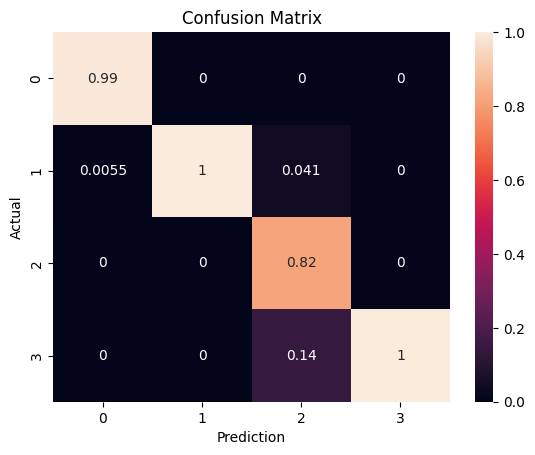

In [40]:
from utils import print_results


print('Test results:')
print_results(
    fit_final_thresholds_metrics['accuracy'],
    fit_final_thresholds_metrics['F1 macro'],
    fit_final_thresholds_metrics['F1 scores'],
    fit_final_thresholds_metrics['confusion matrix'])

Threshold selection improves the results even more, as Label $2$ now obtains better results as well.

## Save the results

In [41]:
import os

models_directory = os.path.join('.', 'model', 'mlp')
os.makedirs(models_directory, exist_ok=True)

results_directory = os.path.join('.', 'results', 'mlp')
os.makedirs(results_directory, exist_ok=True)

In [42]:
import os
import pickle

# Save model and threshold model.
fit_final.save(os.path.join(models_directory, 'fit.model'))
fit_final_thresholds.save(os.path.join(models_directory, 'fit_thresholds.model'))

with open(os.path.join(results_directory, 'val.pickle'), 'wb') as f:
    pickle.dump(avg_validation_results, f)

with open(os.path.join(results_directory, 'test.pickle'), 'wb') as f:
    pickle.dump(fit_final_metrics, f)

with open(os.path.join(results_directory, 'test_thresholds.pickle'), 'wb') as f:
    pickle.dump(fit_final_thresholds_metrics, f)